In [95]:
import utilities
import Loglikeli

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import iv as Iv #Modified Bessel function of the first kind of real order.
import scipy.special as sc

from scipy.stats import rice
import scipy
from scipy.stats.mstats import gmean
from multiprocessing import cpu_count

from utilities import Mask, Bp2f
import copy 

import seaborn as sea
sea.set_style("white")
sea.set_context("talk")
sea.set_style("ticks")

%config Completer.use_jedi = False
%matplotlib inline

In [2]:
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

In [3]:
from getdist import plots, MCSamples
import getdist

In [114]:
from mpi4py import MPI
import traceback

In [4]:
dynesty.__path__

['/global/cscratch1/sd/jianyao/my_test/lib/python3.8/site-packages/dynesty-1.1-py3.8.egg/dynesty']

In [5]:
dynesty.__version__

'1.1'

# simulation data

In [8]:
fres = np.array([2.3, 5, 23, 28.4, 33]); nu0 = gmean(fres); nside = 128

nu0_both = gmean(fres)
nu0_C = gmean([fres[1], fres[2], fres[3], fres[4]])
nu0_S = gmean([fres[0], fres[2], fres[3], fres[4]])

P1 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_14.92_s0_%s_uK_RJ.npy'%nside) ## spass only PYSM simulated results at specific frequency
P1_beamed = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_beamed_14.92_s0_%s_uK_RJ.npy'%nside)

total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/nside_128/totalP_s0_%s_uK_RJ_000.npy'%nside)#/1000 ## from uK to mK
total_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/nside_128/5_fre_sigma_P_%s_uK_RJ_smoothed.npy'%nside)#/1000 ## from uK to mK

mask_spass = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_spass_%s.npy'%nside)
mask_index = np.load('/global/cscratch1/sd/jianyao/CBASS/SPASS_masked_index.npy')

In [4]:
frelist = [0,2,3,4]; P_nu0 = P1_beamed
logL = Loglikeli.logLike(nside, fres,frelist, total_P, total_sigma, 107776)

print(P_nu0[logL.index])

489.31036477453637


In [31]:
npara = 2; 

def prior(cube):
    As = cube[0]*500
    beta = cube[1]*2 - 4
    # beta = cube[1]*0.2 - 3.1
    
    return [As, beta]

def prior_flex(cube, A0):
    
    As = cube[0]*160 + (A0 - 80)
#     beta = cube[1]*2 - 4
    beta = cube[1]*0.2 - 3.1
    
    return [As, beta]
# sampler = dynesty.NestedSampler(logL.loglike, prior_flex, npara, nlive=400, ptform_args = (P_nu0[logL.index],), bootstrap = 0)
sampler = dynesty.NestedSampler(logL.loglike, prior, npara, nlive=400, bootstrap = 0, sample = 'rslice')

sampler.run_nested(dlogz = 0.5, print_progress=True)
results = sampler.results

Text(0.5, 0.98, 'Pixel 107776')

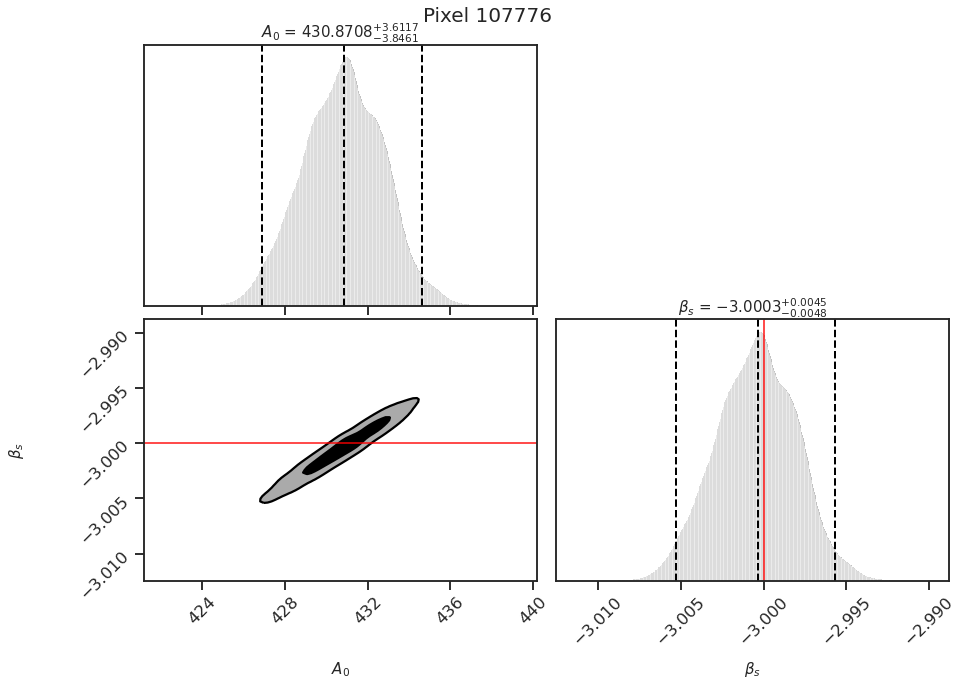

In [28]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

Text(0.5, 0.98, 'Pixel 107776')

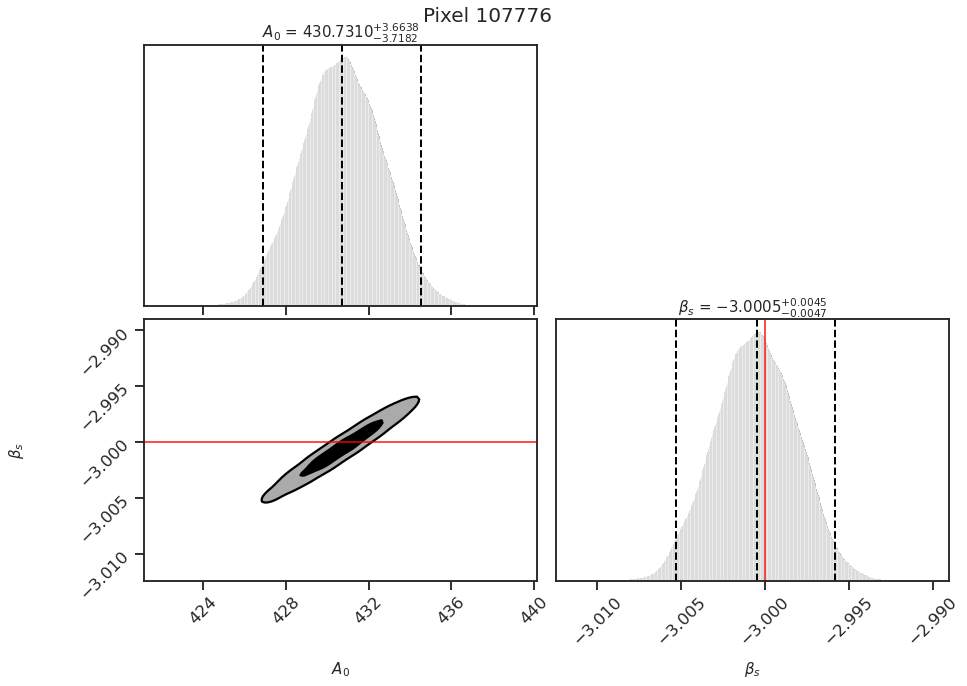

In [7]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

Text(0.5, 0.98, 'Pixel 107776')

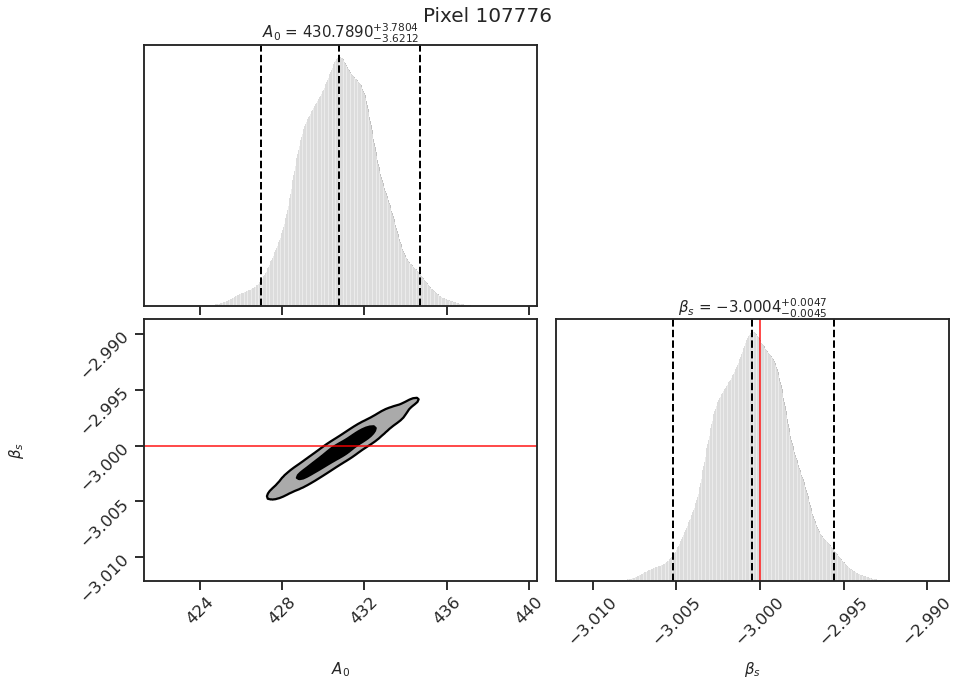

In [9]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results2, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

# likelihood shape

In [ ]:
# x = np.linspace(1427, 1431, 100); 

N = 500


x = np.linspace(428, 434, N)
y= np.linspace(-3.01, -2.99, N)


z = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        z[i, j] = logL.loglike([x[j], y[i]])

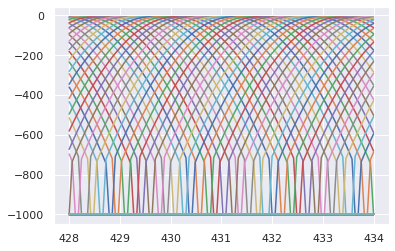

In [223]:
for i in range(100):
    plt.plot(x, znew[:, i])

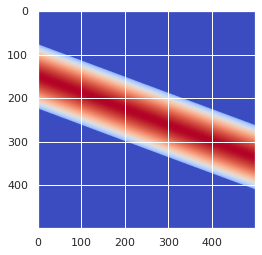

In [244]:
plt.imshow(znew, cmap = 'coolwarm')

In [246]:
znew = copy.copy(z)
znew[z==-1e30] = -1000

In [263]:
sea.set()

In [ ]:
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y, X, znew,linewidth=0, antialiased=False, cmap = 'coolwarm')
ax.view_init(30, 250)
ax.set_xlabel('A0')
ax.set_ylabel(r'$\beta_s$')

Text(0.5, 0, '$\\beta_s$')

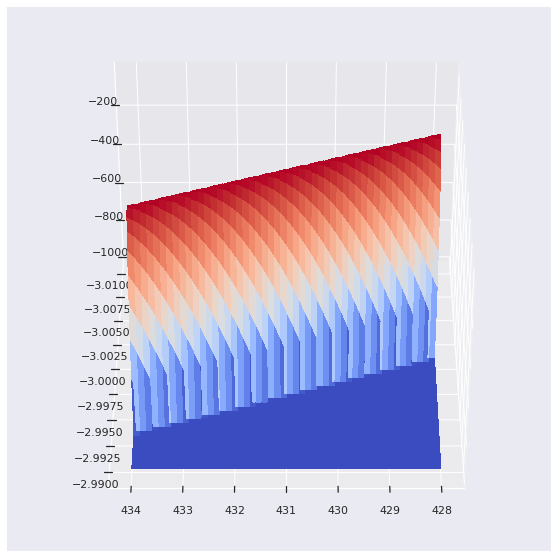

In [248]:
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, znew, linewidth=0, antialiased=False, cmap = 'coolwarm')
ax.view_init(40, 90)

Text(0.5, 0, '$\\beta_s$')

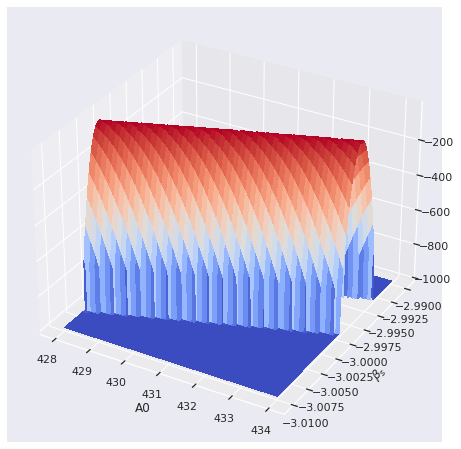

In [266]:
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, znew, cmap = 'coolwarm',linewidth=0, antialiased=False)
ax.set_xlabel('A0')
ax.set_ylabel(r'$\beta_s$')

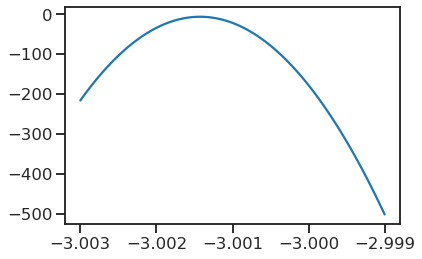

In [31]:
plt.plot(y[0:400], z[250][0:400])

In [32]:
z[z==-1e30]

array([-1.e+30, -1.e+30, -1.e+30, ..., -1.e+30, -1.e+30, -1.e+30])

Text(0, 0.5, 'logL')

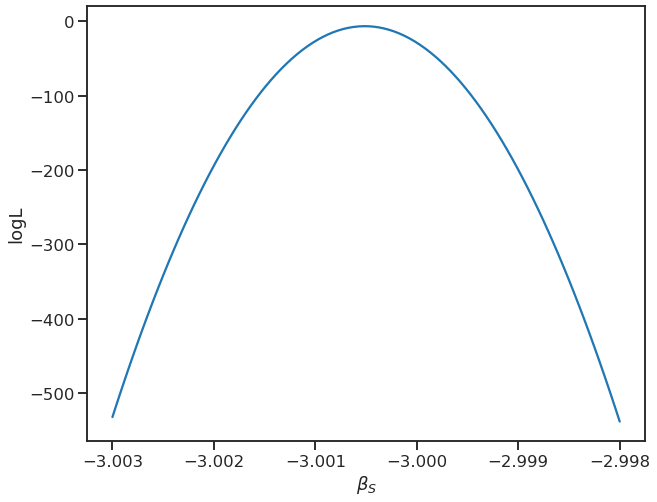

In [11]:
plt.figure(figsize = (10,8))
plt.plot(x, y)
# plt.vlines(x[np.argsort(y)[-1]], -400, 0, color = 'black', ls = '--')
plt.xlabel(r'$\beta_S$')
plt.ylabel('logL')

# Real data

In [177]:
import importlib
importlib.reload(Loglikeli)

<module 'Loglikeli' from '/global/u2/j/jianyao/foreground/Loglikeli.py'>

In [150]:
total_P = np.load('/global/cscratch1/sd/jianyao/Data/total_P_smoothed_128.npy')
total_sigma = np.load('/global/cscratch1/sd/jianyao/Data/total_sigma_smoothed_128.npy')

mask_index = np.load('/global/cscratch1/sd/jianyao/Data/mask_com_smo_128_index.npy')

SNR = np.load('/global/cscratch1/sd/jianyao/Data/SNR_gmean_smoothed_128.npy')

In [151]:
len(mask_index)

41522

In [14]:
np.append(mask_index, np.arange(142)).shape

(41664,)

In [152]:
orders = np.argsort(SNR[mask_index])[::-1]

In [153]:
orders

array([8795, 8796, 8794, ..., 4447, 4609, 4610])

In [157]:
mask_index[orders]

array([151782, 151783, 151781, ...,  33445,  33957,  33958])

In [158]:
SNR[mask_index[orders]][0:]

array([541.9188069 , 530.03719121, 529.33712314, ...,   6.98166765,
         6.80067883,   6.17484151])

In [71]:
SNR[14220+16*10]

106.83360547896847

In [118]:
SNR[164666]

94.24473880877558

In [169]:
if 14220 in mask_index:
    print('True')

True


In [77]:
# for i in mask_index:
#     if i%500 == 0:
#         print(i)

In [170]:
fres = np.array([2.3, 23, 28, 33]); 
# spass, k, lfi, ka
nu0 = gmean(fres); nside = 128

frelist = [0,1,2,3]; 
logL = Loglikeli.logLike(nside, fres,frelist, total_P, total_sigma, 14220) #14220+16*10 #192119 -0.641

In [171]:
npara = 2; 

def prior(cube):
    As = cube[0]*500
    beta = cube[1]*4 - 4
    # beta = cube[1]*0.2 - 3.1
    
    return [As, beta]

def prior_flex(cube, A0):
    
    As = cube[0]*160 + (A0 - 80)
#     beta = cube[1]*2 - 4
    beta = cube[1]*0.2 - 3.1
    
    return [As, beta]
# sampler = dynesty.NestedSampler(logL.loglike, prior_flex, npara, nlive=400, ptform_args = (P_nu0[logL.index],), bootstrap = 0)

try:
    sampler = dynesty.NestedSampler(logL.loglike, prior, npara, nlive=400, bootstrap = 0, sample = 'rslice')
    sampler.run_nested(dlogz = 0.5, print_progress=True)
    
# except Exception as e: 
#     print(e)
    
except Exception:
    traceback.print_exc()
    
results = sampler.results

3273it [01:45, 31.05it/s, +400 | bound: 24 | nc: 1 | ncall: 118032 | eff(%):  3.122 | loglstar:   -inf < -71.351 <    inf | logz: -78.662 +/-    nan | dlogz:  0.001 >  0.500]


In [137]:
logL.index

164666

Text(0.5, 0.98, 'Pixel 14220')

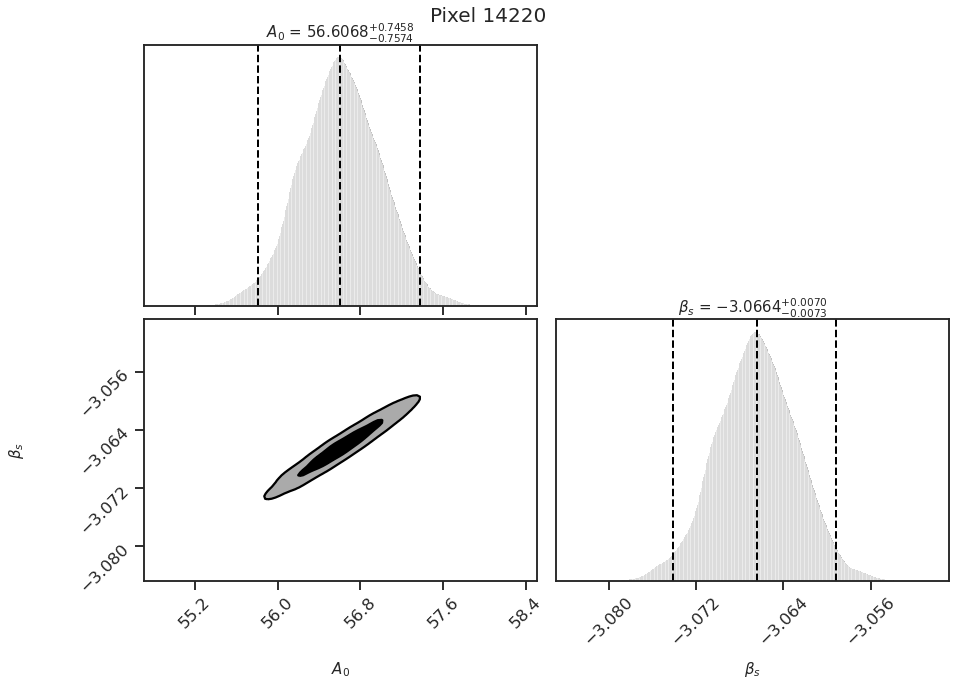

In [172]:
# truth = np.array([P_nu0[logL.index], -3]);
sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 
# truths=truth, 
fig, ax = dyplot.cornerplot(results, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

Text(0.5, 0.98, 'Pixel 151782')

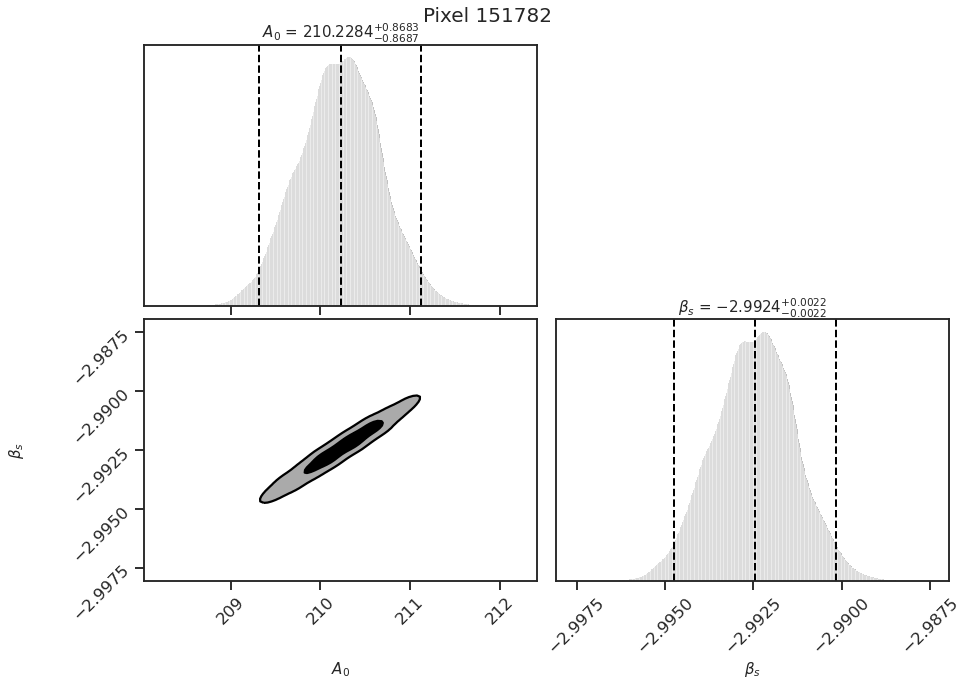

In [161]:
# truth = np.array([P_nu0[logL.index], -3]);
sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 
# truths=truth, 
fig, ax = dyplot.cornerplot(results, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

Removed no burn in


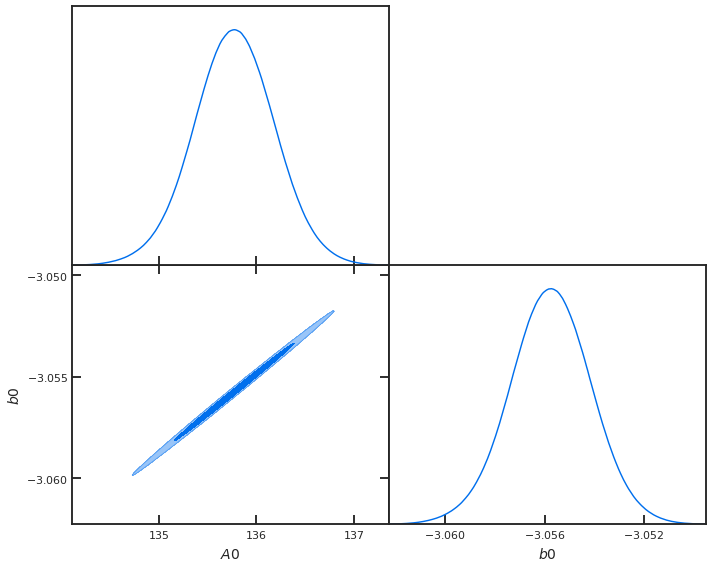

In [231]:
names = ['A0', 'b0']; labels = ['A0', 'b0']
samples1 = MCSamples(samples=results.samples,names = names, labels = labels, weights = weights)

g = plots.get_subplot_plotter(width_inch=10, subplot_size_ratio = 0.8)
g.triangle_plot([samples1], filled=True)

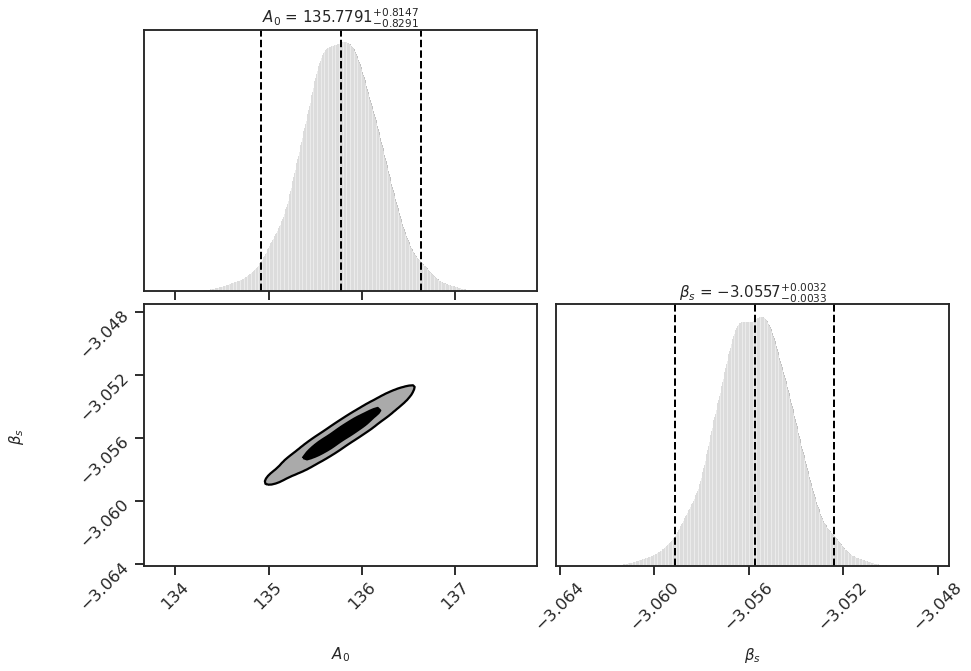

In [235]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(test, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
plt.savefig('test.jpg', format = 'jpg')

In [7]:
18%10

8

In [81]:
from scipy.optimize import curve_fit

In [130]:
def func(x, A0, beta):
    return A0*(x/nu0)**beta

In [164]:
# index = 2715
raw_data_0 = total_P[:,logL.index]
nu_0 = np.array([2.3, 23, 28, 33])

popt, pcov = curve_fit(func, nu_0, raw_data_0)

In [165]:
popt

array([4.59361074, 0.42984225])

In [166]:
raw_data_0

array([2.33413359e-11, 1.16539216e+01, 5.09408238e+00, 2.76420821e+00])

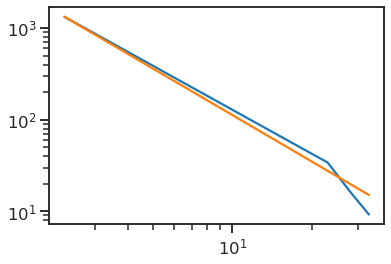

In [146]:
plt.loglog(fres, raw_data_0)
plt.loglog(fres, func(fres, popt[0], popt[1]))

In [144]:
N = 100

x = np.linspace(50, 60, N)
y= np.linspace(-2, -1, N)

z = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        z[i, j] = logL.loglike([x[j], y[i]])

In [141]:
znew = copy.copy(z)
znew[z==-np.inf] = -1000

In [145]:
znew[z!= -np.inf]

array([], dtype=float64)

Text(0.5, 0, '$\\beta_s$')

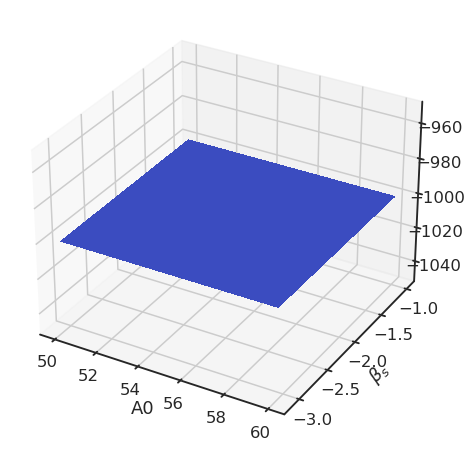

In [142]:
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, znew, cmap = 'coolwarm',linewidth=0, antialiased=False)
ax.set_xlabel('A0')
ax.set_ylabel(r'$\beta_s$')